In [1]:
from ngsolve import *
import netgen.gui
import numpy as np
import scipy
import scipy.sparse as sparse
import math
from netgen.geom2d import *
import scipy.sparse as sp
import matplotlib.pyplot as plt

In [2]:


geo = SplineGeometry()

r1 = 2.5
r2 = 1
h1 = 5
h2 = 1.5
h3 = 1
d = 0.2


x_val = [0, 2*r1, 2*r1, r1+r2, r1+r2, r1+r2-d, r1+r2-d, 2*r1-d, 2*r1-d, d, d, r1-r2+d, r1-r2+d, r1-r2, r1-r2, 0]
y_val = [0, 0, h1, h1+h2, h1+h2+h3, h1+h2+h3, h1+h2, h1, d, d, h1, h1+h2, h1+h2+h3, h1+h2+h3, h1+h2, h1]

assert len(x_val)==len(y_val), "lengths of x and y values must be the same"
points = [None]*len(x_val)
amount_points = len(points)
for j in range(0,amount_points):
    points[j] = geo.AppendPoint(x_val[j], y_val[j])

for j in range(0,amount_points):
    geo.Append(["line", points[j], points[(j+1) % amount_points]], leftdomain=0, rightdomain=1, bc = "bottle")

geo.AddRectangle((-1,-1),(2*r1+1, h1+h2+h3+1), bc="robin")
geo.SetMaterial (1, "air")
geo.SetMaterial (2, "glass")

mesh = Mesh(geo.GenerateMesh(maxh=0.2))
Draw(mesh)

fes = H1(mesh, order=5, complex=True, definedon="air")#, dirichlet="bottle")

## peak on top of bottle
source = 1000*exp(-(4**2)*((x-2.5)**2 + (y-(h1+h2+h3+0.3))**2))
Draw(source,mesh,name = "pulse")

In [3]:
maxind = 20
#fes = H1(mesh, order=5,complex = True)
fes = H1(mesh, order=5,dirichlet=".*")
gfu = GridFunction(fes,name = "u")
erg = np.zeros([len(gfu.vec),maxind],dtype = complex)
fh = np.zeros(len(gfu.vec),dtype = complex)

In [4]:
u = fes.TrialFunction()
v = fes.TestFunction()

A = BilinearForm(fes)
K = BilinearForm(fes)
M = BilinearForm(fes)
F = LinearForm(fes)
#R = BilinearForm(fes)

omega = Parameter(1)
A += (grad(u)*grad(v)- omega**2*u*v)*dx
K += grad(u)*grad(v)*dx
M += u*v*dx
#R += -1j*u*v*ds(definedon=mesh.Materials('glas'))
#A += -1j*omega*u*v*ds(definedon=mesh.Materials('glas'))


#A += 1j*omega*u*v*ds # R 
F += source*v*dx  
o = []  

norm = []

#o = verg[0:21]
for i in range(0,maxind):
    o.append(i)

j = 0
Draw(gfu)
for i in o:   
    omega.Set(i) 
    A.Assemble()
    K.Assemble()
    M.Assemble()
    F.Assemble()  
    #R.Assemble() 
    gfu.vec.data = A.mat.Inverse(fes.FreeDofs()) * F.vec
    erg[:,j] = gfu.vec
    fh = F.vec
    norm.append(sqrt (Integrate ((gfu)*(gfu),mesh)))
    print("Number of iter: ",j,"omega: ",i,"L2-Norm:",sqrt (Integrate ((gfu)*(gfu),mesh)))
    j = j+1
#As = A.mat
Ms = M.mat
Ks = K.mat
#Rs = R.mat
rows,cols,vals = Ms.COO()
Mh = sp.csr_matrix((vals,(rows,cols)))
rows,cols,vals = Ks.COO()
Kh = sp.csr_matrix((vals,(rows,cols)))
#rows,cols,vals = Rs.COO()
#Rh = sp.csr_matrix((vals,(rows,cols)))
#rows,cols,vals = As.COO()
#Ah = sp.csr_matrix((vals,(rows,cols)))
#Ah = sp.csr_matrix.toarray(Ah)

Number of iter:  0 omega:  0 L2-Norm: 34.78223957236353
Number of iter:  1 omega:  1 L2-Norm: 43.892809331549124
Number of iter:  2 omega:  2 L2-Norm: 9340.852658498954
Number of iter:  3 omega:  3 L2-Norm: 175.41271403669657
Number of iter:  4 omega:  4 L2-Norm: 139.77610903006124
Number of iter:  5 omega:  5 L2-Norm: 315.8896957090934
Number of iter:  6 omega:  6 L2-Norm: 160.88447888068103
Number of iter:  7 omega:  7 L2-Norm: 153.95683346936352
Number of iter:  8 omega:  8 L2-Norm: 112.82272302768075
Number of iter:  9 omega:  9 L2-Norm: 195.48007467988324
Number of iter:  10 omega:  10 L2-Norm: 124.93169104714036
Number of iter:  11 omega:  11 L2-Norm: 35.72422427591956
Number of iter:  12 omega:  12 L2-Norm: 12.370069779672724
Number of iter:  13 omega:  13 L2-Norm: 14.515581941377482
Number of iter:  14 omega:  14 L2-Norm: 1171.044466564229
Number of iter:  15 omega:  15 L2-Norm: 4.1724806504192955
Number of iter:  16 omega:  16 L2-Norm: 10.508498030138995
Number of iter:  17 om

In [5]:
V, r = np.linalg.qr(erg)
V = erg.dot(np.linalg.inv(r))
print(np.vdot(V[:,1],(V[:,2])))
len(V)

(-1.301261478125935e-16+0j)


45845

Text(0, 0.5, 'Euklidic-Norm')

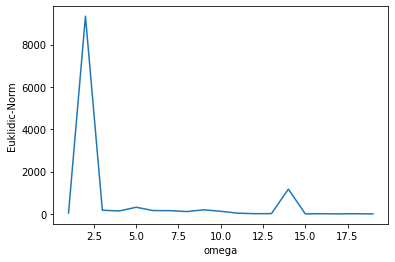

In [6]:
plt.plot(o[1:20],norm[1:20])
plt.xlabel("omega")
plt.ylabel("Euklidic-Norm")
#plt.savefig('results/resonanz_20.png')

In [7]:
MN = np.transpose(V).dot(Mh.dot(V))
KN = np.transpose(V).dot(Kh.dot(V))
fN = np.transpose(V).dot(fh)
#RN = np.transpose(V).dot(Rh.dot(V))

In [8]:
iteration = int(100)
interval = 20
factor = interval / iteration
omegaN = []
norm_L2 =[]
uN = np.zeros([maxind,iteration])
for i in range(iteration):
    omegaN.append(factor*i)
    #uN[:,i] = np.linalg.solve(KN-omegaN[i]**2*MN+omegaN[i]*RN, fN)
    uN[:,i] = np.linalg.solve(KN-omegaN[i]**2*MN, fN)
    new = uN[:,i].dot(np.transpose(V))
    gif = GridFunction(fes,name = "gif")
    gif.vec.FV().NumPy()[:] = new
    Draw(gif)
    print("i: ",i,"Omega: ",omegaN[i])
    input()
    Redraw()
    #norm_L2.append(sqrt(uN[:,i].dot(uN[:,i])))

i:  0 Omega:  0.0
i:  1 Omega:  0.2
i:  2 Omega:  0.4
i:  3 Omega:  0.6000000000000001
i:  4 Omega:  0.8
i:  5 Omega:  1.0
i:  6 Omega:  1.2000000000000002
i:  7 Omega:  1.4000000000000001
i:  8 Omega:  1.6
i:  9 Omega:  1.8
i:  10 Omega:  2.0
i:  11 Omega:  2.2
i:  12 Omega:  2.4000000000000004
i:  13 Omega:  2.6
i:  14 Omega:  2.8000000000000003
i:  15 Omega:  3.0
i:  16 Omega:  3.2
i:  17 Omega:  3.4000000000000004
i:  18 Omega:  3.6
i:  19 Omega:  3.8000000000000003
i:  20 Omega:  4.0
i:  21 Omega:  4.2
i:  22 Omega:  4.4


KeyboardInterrupt: Interrupted by user

In [ ]:
iteration = int(1e4)
interval = 20
factor = interval / iteration
omegaN = []
norm_L2 =[]
res = []
uN = np.zeros([maxind,iteration])
for i in range(iteration):
    print(i)
    omegaN.append(factor*i)
    uN[:,i] = np.linalg.solve(KN-omegaN[i]**2*MN, fN)
    res.append(np.linalg.norm((Kh-omegaN[i]**2*Mh).dot(uN[:,i].dot(np.transpose(V)))-fN.dot(np.transpose(V))))
    norm_L2.append(sqrt(uN[:,i].dot(uN[:,i])))

In [ ]:
#plt.semilogy(verg[0:maxpoints],point[0:maxpoints],'*r')
plt.semilogy(omegaN[10:],norm_L2[10:],'b')
plt.xlabel("omega")
plt.ylabel("Euclidic Norm")
#plt.savefig('results/resonanz_RB_20.png')